In [77]:
# Import packages
%reset -f
from helpers import load_all_data, vectorized_flatten, sigmoid, get_log_loss, get_accuracy 
from helpers import sigmoid_derivative, gradient_update, plot_loss, prep_data, get_best_results, get_results
import numpy as np
import cv2

In [78]:
def initialize(X, h1, h2): 
    '''
    --------------------
    Parameter Initialization
    --------------------
    Parameters: 
    X: Numpy array of training features (shape = nxm)
    --------------------
    Output: 
    weights: Weight terms initialized as random normals
    biases: Bias terms initialized to zero
    --------------------
    '''
    dim1 = 1/np.sqrt(X.shape[0])
    W1 = dim1 * np.random.randn(h1, 28**2)
    
    dim2 = 1/np.sqrt(W1.shape[1])
    W2 = dim2 * np.random.randn(h2, h1)
    
    dim3 = 1/np.sqrt(W2.shape[1])
    W3 = dim3 * np.random.randn(1, h2)

    b1 = np.zeros((h1, 1))
    b2 = np.zeros((h2, 1))
    b3 = np.zeros((1, 1))
    
    weights = [W1, W2, W3]
    biases = [b1, b2, b3]
    
    return weights, biases

In [79]:
def forward_pass(X, weights, biases):
    '''
    ----------------------------------
    Forward propogation:
    Send inputs through the network to
    generate output
    ----------------------------------
    Parameters: 
    X: Numpy array of training features (shape = nxm)
    weights: List of weights 
    biases: List of biases
    --------------------
    Output: 
    activations: List of forward pass terms
    --------------------
    '''
    W1, W2, W3 = weights
    b1, b2, b3 = biases
    
    z1 = W1 @ X + b1
    a1 = sigmoid(z1)
    
    z2 = W2 @ a1 + b2
    a2 = sigmoid(z2)
    
    z3 = W3 @ a2 + b3
    a3 = sigmoid(z3)
    
    activations = [z1, a1, z2, a2, z3, a3]
    
    return activations

In [80]:
def backpropagation(X, y, weights, biases, activations):
    '''
    --------------------
    Backpropagation
    --------------------
    Parameters: 
    X: Numpy array of training features (shape = nxm)
    y: Binary (1/0) training label (shape = 1xm)
    weights: Current set of weights
    biases: Current set of biases
    activations: Current set of activations
    --------------------
    Output: 
    Gradients required
    for optimization update
    --------------------
    '''
    W1, W2, W3 = weights
    b1, b2, b3 = biases
    z1, a1, z2, a2, z3, a3 = activations
    m = max(y.shape)
    # print(m)
    
    dz3 = (a3 - y)/m
    # print("dz3", dz3.shape)
    
    dW3 = np.dot(dz3, a2.T)
    # print("dW3", dW3.shape)
    
    db3 = np.sum(dz3, axis=1).reshape(-1, 1)
    # print("db3", db3.shape)
    
    da2 = np.dot(W3.T, dz3)
    # print("da2", da2.shape)
    
    dz2 = da2 * sigmoid_derivative(z2)
    # print("dz2", dz2.shape)
    
    dW2 = np.dot(dz2, a1.T)
    # print("dW2", dW2.shape)
    
    db2 = np.sum(dz2, axis=1).reshape(-1, 1)
    # print("db2", db2.shape)
    
    da1 = np.dot(W2.T, dz2)
    # print("da1", da1.shape)
    
    dz1 = da1 * sigmoid_derivative(z1)
    # print("dz1", dz1.shape)
    
    dW1 = np.dot(dz1, X.T)
    # print("dW1", dW1.shape)
    
    db1 = np.sum(dz1, axis=1).reshape(-1, 1)
    # print("db1", db1.shape)
    
    return db1, dW1, db2, dW2, db3, dW3

In [81]:
def update_parameters(weights, biases, gradients, learning_rate):
    '''
    --------------------
    Update parameters
    --------------------
    Parameters: 
    weights: Current set of weights
    biases: Current set of biases
    gradients: Current set of gradients
    learning_rate: parameter to guide SGD step size
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    W1, W2, W3 = weights
    b1, b2, b3 = biases
    
    db1, dW1, db2, dW2, db3, dW3 = gradients
    
    W1 = gradient_update(W1, learning_rate, dW1)
    W2 = gradient_update(W2, learning_rate, dW2)
    W3 = gradient_update(W3, learning_rate, dW3)
   
    b1 = gradient_update(b1, learning_rate, db1)
    b2 = gradient_update(b2, learning_rate, db2)
    b3 = gradient_update(b3, learning_rate, db3)
    
    weights = [W1, W2, W3]
    biases = [b1, b2, b3]
    
    return [weights, biases]

In [82]:
def finite_differences(example, truth, weights, biases, delta_h=1e-7):
    '''
    --------------------
    Calculate gradients using finite differences. 
    Calculate norm of differences between finite difference gradients and backpropogation gradients.
    --------------------
    Parameters: 
    example: Some training example
    truth: Label of that training example
    weights: Current set of weights
    biases: Current set of biases
    delta_h: Finite differences epsilon term
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    W1, W2, W3 = weights
    b1, b2, b3 = biases
    
    activations = forward_pass(example, weights, biases)
    db1, dW1, db2, dW2, db3, dW3 = backpropagation(example, truth, weights, biases, activations)
    
    
    weight_gradients = [dW1, dW2, dW3]
    bias_gradients = [db1, db2, db3]
    
    deltaW_lst = []
    weight_differences = []
    for l in range(len(weights)):
        I, J = weights[l].shape 
        

        deltaW_lst.append(np.zeros((I, J)))
        for i in range(I):
            for j in range(J):

                weights[l][i][j] += delta_h
                activations_plus = forward_pass(example, weights, biases)
                
                weights[l][i][j] -= 2* delta_h
                activations_minus = forward_pass(example, weights, biases)
                
                weights[l][i][j] += delta_h

#                 W_minus[i][j] -= delta_h

#                 weights_plus = [W1, W2, W_plus] # Change here
#                 weights_minus = [W1, W2, W_minus] # Change here



#                 weights[l][i][j] += delta_h

                loss_plus = get_log_loss(truth, activations_plus[-1])
                loss_minus =  get_log_loss(truth, activations_minus[-1])

                deltaW_lst[l][i][j] = (loss_plus - loss_minus)/(2 * delta_h)

        difference = np.linalg.norm(weight_gradients[l] - deltaW_lst[l]) # Change here
        weight_differences.append(difference)
        
        
    deltab_lst = []
    bias_differences = []
    for l in range(len(biases)):
        I, J = biases[l].shape 
        

        deltab_lst.append(np.zeros((I, J)))
        for i in range(I):
            for j in range(J):

                biases[l][i][j] += delta_h
                activations_plus = forward_pass(example, weights, biases)
                
                biases[l][i][j] -= 2* delta_h
                activations_minus = forward_pass(example, weights, biases)
                
                biases[l][i][j] += delta_h

#                 W_minus[i][j] -= delta_h

#                 weights_plus = [W1, W2, W_plus] # Change here
#                 weights_minus = [W1, W2, W_minus] # Change here



#                 weights[l][i][j] += delta_h

                loss_plus = get_log_loss(truth, activations_plus[-1])
                loss_minus =  get_log_loss(truth, activations_minus[-1])

                deltab_lst[l][i][j] = (loss_plus - loss_minus)/(2 * delta_h)

        difference = np.linalg.norm(bias_gradients[l] - deltab_lst[l]) # Change here
        bias_differences.append(difference)
        
    #print("W3 finite difference vs gradient")
    #print(deltaW_lst[-1])
    #print(dW3)
    
    #print("b3 finite difference vs gradient")
    #print(deltab_lst[-1])
    #print(db3)
    
    #print("W2 finite difference vs gradient")
    #print(deltaW_lst[-2])
    #print(dW2)
    
    #print("b2 finite difference vs gradient")
    #print(deltab_lst[-2])
    #print(db2)
    
    #print("W1 finite difference vs gradient")
    #print(deltaW_lst[-3])
    #print(dW1)
    
    #print("b1 finite difference vs gradient")
    #print(deltab_lst[-3])
    #print(db1)
    
    return weight_differences, bias_differences

In [83]:
def run_finite_differences(X_train_flattened, y_train, weights, biases, idx=10):
    '''
    --------------------
    Run finite differerences
    --------------------
    Parameters:
    weights: Current set of weights
    biases: Current set of biases
    --------------------
    Output: 
    Updated weights and biases
    --------------------
    '''
    weight_differences, bias_differences = finite_differences(X_train_flattened[:, idx].reshape(-1, 1), y_train[:, idx].reshape(-1, 1), weights, biases)
    
    #print("weight_differences", weight_differences)
    #print("bias_differences", bias_differences)

In [84]:
def train(X, y, X_val, y_val, w, b, h1, h2, lr, epochs, tolerance=1e-1):    
    '''
    --------------------
    Prepare data
    --------------------
    Parameters: 
    X: Training set features
    y: Training set labels
    X_val: Validation set features
    y_val: Validation set labels
    w: Initialized list of weight matrices
    b: Initialized list of bias matrices
    h1: Number of neurons in 1st layer
    h2: Number of neurons in 2nd layer
    lr: Learning rate
    epochs: Max epochs
    tolerance: Minimum reduction in loss over 10 epochs, used for convergence check
    --------------------
    Output: 
    Training History containing metrics and weights/biases at each epoch
    --------------------
    '''
    # Initialize history dictionary
    history = {
        "weights": [w],
        "losses": [],
        "val_losses": [],
        "biases": [b],
        "accuracies": [],
        "val_accuracies": []
    }
    
    convergence_counter = 0
    best_loss = np.inf
    
    # Do this for the specified epochs
    for epoch in range(epochs):
        
        # Get weights and bias
        w = history['weights'][epoch]
        b = history['biases'][epoch]
        
        # Forward pass to get activations
        activations = forward_pass(X, w, b)
        
        # Forward pass to get validation activations
        val_activations = forward_pass(X_val, w, b)
              
        # Backward pass to get gradients
        gradients = backpropagation(X, y, w, b, activations)
        
        # Gradient descent update
        w, b = update_parameters(w, b, gradients, lr)
    
        # Get last layer output
        y_prob = activations[-1]
        y_val_prob = val_activations[-1]
        
        # Threshold
        y_pred = np.where(y_prob > 0.5, 1, 0)
        y_val_pred = np.where(y_val_prob > 0.5, 1, 0)
    
        # Get loss and accuracy results
        loss = get_log_loss(y, y_prob)
        accuracy = get_accuracy(y, y_pred)
        
        # Get loss and accuracy results for validation set
        val_loss = get_log_loss(y_val, y_val_prob)
        val_accuracy = get_accuracy(y_val, y_val_pred)
         
        # Check convergence, keeps a counter of how many epochs it has been without an improvement
        # Counter resets whenever there's an improvent            
        if loss < best_loss - tolerance:
            best_loss = loss
            convergence_counter = 0
        else:
            convergence_counter += 1

        # Append results to history
        history["losses"].append(loss)
        history["val_losses"].append(val_loss)
        history["biases"].append(b)
        history["weights"].append(w)
        history["accuracies"].append(accuracy)
        history["val_accuracies"].append(val_accuracy)
        
        # 10 epochs without an improvment is considered to have converged
        if convergence_counter == 10:
            break
        
        # Display loss for monitoring
        #print(loss)
        
        # Stop training if numerical loss underflows
        if np.isnan(loss): break
        
        # Store loss for next epoch
        previous_accuracy = accuracy
    
    # Return statement
    return(history)

In [85]:
def get_results(X_dev, y_dev, history, best_epoch, label="dev"):
    '''
    --------------------
    Get metrics given epoch, history and set
    --------------------
    Parameters: 
    X_dev: Features matrix
    y_dev: labels vector
    history: History containing metrics collected during training
    best_epoch: Epoch number to index history
    label: Specify type of set ie. test, train, dev
    --------------------
    Output: 
    Accuracy at specified epoch
    --------------------
    '''
    w = history["weights"][best_epoch]
    b = history["biases"][best_epoch]
    activations = forward_pass(X_dev, w, b)

    y_dev_prob = activations[-1]
    y_dev_pred = np.where(y_dev_prob > 0.5, 1, 0)

    loss = get_log_loss(y_dev, y_dev_prob)
    accuracy = get_accuracy(y_dev, y_dev_pred)
    #print(f"{label} set accuracy at best epoch: {accuracy}")
    #print(f"{label} set loss at best epoch: {loss}")
    
    return(accuracy)

In [86]:
def execute_pipeline(data_path, h1, h2, lr, epochs):
    '''
    --------------------
    Execute Pipeline
    --------------------
    Parameters: 
    data_path: Folder where data is stored
    h1: Number of neurons in 1st layer
    h2: Number of neurons in 2nd layer
    lr: Learning rate
    epochs: Max number of epochs
    --------------------
    Output: 
    Training History containing metrics and weights/biases at each epoch
    --------------------
    '''
    # Set seed for reproducible results
    np.random.seed(1252908)

    # Get data
    X_train_flattened, X_dev_flattened, X_test_flattened, y_train, y_dev, y_test = prep_data(data_path)

    # Initialize weights
    weights, biases = initialize(X_train_flattened, h1, h2)

    # Check finite difference
    idx = np.random.choice(range(X_train_flattened.shape[1]))
    run_finite_differences(X_train_flattened, y_train, weights, biases, idx=idx)
    
#     # Check finite difference
    idx = np.random.choice(range(X_train_flattened.shape[1]))
    run_finite_differences(X_train_flattened, y_train, weights, biases, idx=idx)
    
    # Now enter training loop
    training_history = train(X_train_flattened, y_train, X_dev_flattened, y_dev, weights, biases, h1, h2, lr, epochs)
    
    # Display plots to monitor whether loss functions are correct shape
    plot_loss("loss.png", training_history["losses"][:-2])
    
    # Plot accuracy
    plot_loss("accuracy.png", training_history["accuracies"][:-2], label='Training Accuracy')
    
    # Display plots to monitor whether loss functions are correct shape
    plot_loss("val_loss.png", training_history["val_losses"][:-2], label='Validation Loss')
    
    # Plot accuracy
    plot_loss("val_accuracy.png", training_history["val_accuracies"][:-2], label='Validation Accuracy')
    
    # Get weights and biases from best training epoch
    best_training_epoch, best_training_accuracy, best_training_loss = get_best_results(training_history, metric='val_accuracies')
    
    # Get dev results
    get_results(X_dev_flattened, y_dev, training_history, best_training_epoch)
    
    # Get test results
    get_results(X_test_flattened, y_test, training_history, best_training_epoch, label="test")
    
    return training_history

In [87]:
# Set path to data
data_path = '../setup/data'

In [88]:
# Set perceptron parameters: architecture, learning rate, and no. of training epochs
h1 = 8
h2 = 4
lr = 0.1
epochs = 1000

training accuracy at best epoch: 0.5
training loss at best epoch: 9467.212521647147
best epoch: 0
training accuracy at best epoch: 0.5310833333333334
training loss at best epoch: 8281.500612161788
best epoch: 998
training accuracy at best epoch: 0.9515
training loss at best epoch: 2920.9083728551577
best epoch: 991
training accuracy at best epoch: 0.9596666666666667
training loss at best epoch: 2037.2745171495267
best epoch: 132
training accuracy at best epoch: 0.5
training loss at best epoch: 8856.98510033028
best epoch: 0
training accuracy at best epoch: 0.5
training loss at best epoch: 8856.98510033028
best epoch: 0
training accuracy at best epoch: 0.94175
training loss at best epoch: 4029.518069747831
best epoch: 944
training accuracy at best epoch: 0.9549166666666666
training loss at best epoch: 2116.535536134076
best epoch: 133
training accuracy at best epoch: 0.5
training loss at best epoch: 8346.80866556109
best epoch: 0
training accuracy at best epoch: 0.78825
training loss at

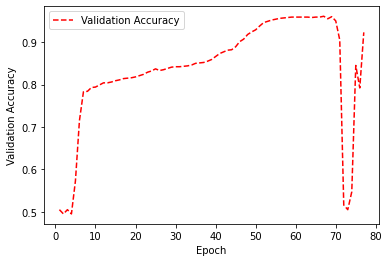

In [89]:
lrs = [0.001, 0.01, 0.1, 1]
h2s = [2, 4, 8, 16]
h1s = np.array(h2s) *2

histories = []
losses = []
for h1, h2 in zip(h1s, h2s):
    for lr in lrs: 
        # Execute pipeline
        history = execute_pipeline(data_path, h1, h2, lr, epochs)
        epoch = np.array(history["val_accuracies"]).argmax()
        best_accuracy = history["val_accuracies"][epoch]
        best_loss = history["val_losses"][epoch]
        losses.append(best_loss)
        histories.append([h1, h2, lr, best_accuracy, best_loss])

In [90]:
histories[np.array(losses).argmin()]

[32, 16, 0.1, 0.968, 108.9245727116274]

training accuracy at best epoch: 0.9608333333333333
training loss at best epoch: 1523.5964086873812
best epoch: 989


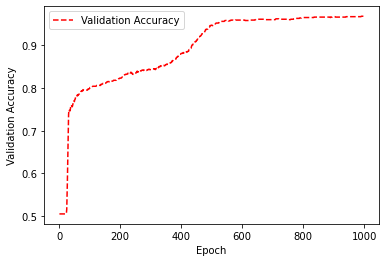

In [93]:
history = execute_pipeline(data_path, 32, 16, 0.1, 10000)